In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scstats

# Monte Carlo approximation of the Greeks

## 1. Monte Carlo approximation of $C_0$

Our asset price $S_t$ follows the Black-Scholes model under risk-neutral probability
$$
    dS_t = S_t(r\,dt + \sigma\,dB_t)
$$
so that
$$
    S_t = S_0\exp\left(\left(r-\frac{\sigma^2}{2}\right)t + \sigma B_t\right).
$$

We are looking at a binary option $\mathbf{1}_{\{S_T\leq K\}}$ on the asset $S$, of strike $K$ and maturity $T$.

The optimal hedging strategy is given by
$$
    C_0 = e^{-rT}\mathbb E[\mathbf 1_{\{S_T\leq K\}}] = e^{-rT}\mathbf N(-d_-(X_0,\sigma^2T))
    \qquad
    \Delta_0 = e^{-rT}\partial_{S_0}\mathbb E[\mathbf 1_{\{S_T\leq K\}}] = \frac{e^{-rT}}{S_0\sigma\sqrt{T}}\mathbf N'(-d_-(X_0,\sigma^2T))
$$
with
$$
    X_0 = \frac{S_0}{Ke^{-rT}}\qquad d_{-}(x,v) = \frac{\ln(x)}{\sqrt v} - \frac12\sqrt v.
$$

### 1.a) Straight computation

We first use the explicit formula to compute the Greeks.

In [2]:
def dminus(x,v):
    """
    Compute :math:`d_{-}(x,v)`
    """
    sqrv = np.sqrt(v)
    return np.log(x)/sqrv - 0.5*sqrv

In [237]:
def strategy(r, sigma, s0, tmax, k):
    """
    Args:
        k: option strike, either float or array
    
    Returns:
        Tuple of Greeks C_0, Delta_0
    """
    dscnt = np.exp(-r*tmax) # discount factor
    x0 = s0/(k*dscnt)
    sigt2 = sigma*sigma*tmax
    dm_c = dminus(x0, sigt2)
    c0 = dscnt*scstats.norm.cdf(-dm_c)
    delt0 = -dscnt/(s0*np.sqrt(sigt2))*scstats.norm.pdf(-dm_c)
    return c0, delt0

In [238]:
r = 0.02
sigm0 = 0.4
s0 = 100
tmax = 0.9
k_range = np.array(range(80, 80+40+1))

In [239]:
strategy(r, sigm0, s0, tmax, k_range[0])

(0.3220459673863255, -0.009349088628238819)

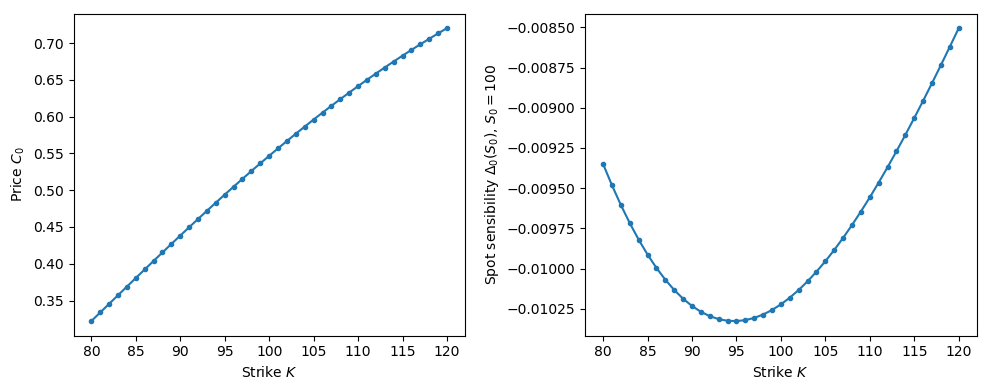

In [247]:
price, sensib = strategy(r, sigm0, s0, tmax, k_range)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), dpi=100)
ax0.plot(k_range, price, marker='.')
ax0.set_ylabel("Price $C_0$")
ax0.set_xlabel("Strike $K$")
ax1.plot(k_range, sensib, marker='.')
ax1.set_ylabel("Spot sensibility $\Delta_0(S_0)$, $S_0=100$")
ax1.set_xlabel("Strike $K$")
fig.tight_layout()

### 1.b) Monte Carlo approximation

We do not need to compute complete Brownian trajectories: we can just use the fact that $B_T \sim \mathcal N(0, T)$ and
$$
    S_T = S_0 e^{\left(r-\sigma^2/2\right)T + \sigma B_T}.
$$

In [59]:
def monte_carlo_price(r, sigma, s0, tmax, k, n_samples):
    """
    Monte Carlo simulation of the option price

    Args:
        r: interest rate
        sigma: volatility
        s0: spot
        tmax: max time horizon
        k: option strike, float or (nk,)-array
        n_samples: number of Monte Carlo samples
    """
    if isinstance(k, np.ndarray):
        # Reshape the array to (nk, 1)
        # to fit the broadcasting rules
        k = k[:, None]
    bt = np.sqrt(tmax)*np.random.randn(n_samples)
    st = s0*np.exp((r - sigma*sigma/2)*tmax + sigma*bt)
    payoff = (st <= k)
    discount = np.exp(-r*tmax)
    return discount*np.mean(payoff.T, axis=0)

In [100]:
monte_carlo_price(r, sigm0, s0, tmax, k_range, 1000)

array([0.32705962, 0.33688123, 0.34964933, 0.36143526, 0.37322119,
       0.38206064, 0.4007217 , 0.41054331, 0.41348979, 0.43215085,
       0.44590111, 0.45572272, 0.46259785, 0.47536594, 0.48715187,
       0.49697348, 0.51072374, 0.5166167 , 0.52054535, 0.52840264,
       0.54411721, 0.55884963, 0.56768908, 0.57849285, 0.59126094,
       0.60108255, 0.609922  , 0.61483281, 0.62072577, 0.62563658,
       0.64036899, 0.6501906 , 0.65411925, 0.6629587 , 0.67376247,
       0.69144137, 0.69929866, 0.70224514, 0.70617378, 0.71206675,
       0.71501323])

### 1.c) Comparison

In [134]:
N_mc = 1000 # sample size of the Monte Carlo estimator
M_mc = 100  # number of Monte Carlo simulations
mc_c0_sims = np.stack([
    monte_carlo_price(r, sigm0, s0, tmax, np.array(k_range), N_mc) for _ in range(M_mc)
])

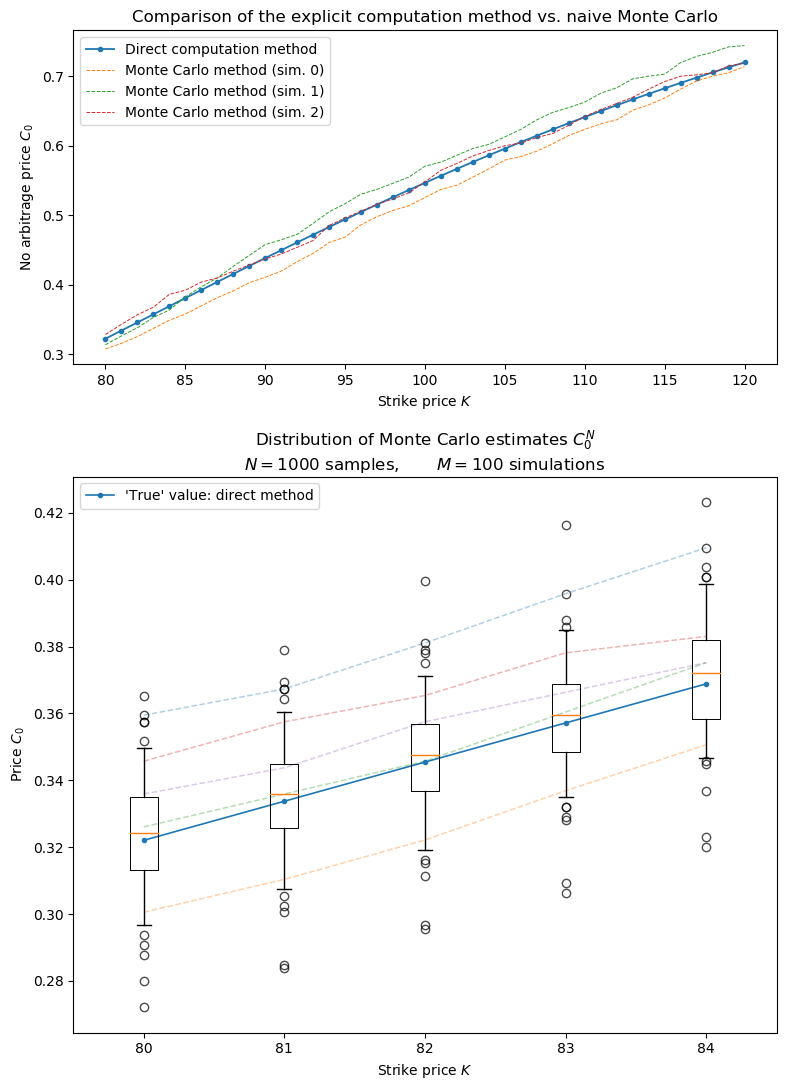

In [167]:
fig, (ax0, ax1) = plt.subplots(2, 1,
                               gridspec_kw={'height_ratios':[1.5,2.5]},
                               figsize=(8,11), dpi=100)

direct_compute_c0, _ = strategy(r, sigm0, s0, tmax, np.array(k_range))
ax0.plot(np.array(k_range), direct_compute_c0, zorder=1,
        linewidth=1.3, marker='.', label="Direct computation method")
for i, mc_c0_ in enumerate(mc_c0_sims[:3]):
    ax0.plot(np.array(k_range), mc_c0_,
            linestyle='--',
            linewidth=.7, label="Monte Carlo method (sim. %d)" % i)
ax0.set_xlabel("Strike price $K$")
ax0.set_ylabel("No arbitrage price $C_0$")
ax0.set_title("Comparison of the explicit computation method vs. naive Monte Carlo")
ax0.legend()

k_index = np.array([0, 1, 2, 3, 4])
ax1.plot(k_range[k_index], mc_c0_sims[5:10, k_index].T,
         linestyle='--',
         alpha=0.35,
         linewidth=1.1)
ax1.plot(k_range[k_index], direct_compute_c0[k_index],
         linestyle='-', marker='.',
         alpha=1.0, color='C0',
         label="'True' value: direct method",
         linewidth=1.2)
boxplot_dict = ax1.boxplot(mc_c0_sims[:, k_index],
            positions=k_range[k_index],
            whis=[5, 95], # set whiskers to 5% and 95%
            widths=0.2)
for fl in boxplot_dict['fliers']:
    fl.set_alpha(.7)
    fl.set_color('blue')
for b in boxplot_dict['boxes']:
    b.set_linewidth(.7)
ax1.set_xlabel("Strike price $K$")
ax1.set_ylabel("Price $C_0$")
ax1.set_title("Distribution of Monte Carlo estimates $C_0^N$\n$N=%d$ samples,\t$M=%d$ simulations" % (N_mc,M_mc) )
ax1.legend()
fig.tight_layout()

The distribution of $C_0^N$ is given for different strike values $K$.

The whiskers are at 5% and 95% of the distribution.

As expected, the price of the binary option increases with the strike: the higher the strike the more likely we are to get the unit payoff.

The Monte Carlo approximation method has quite a bit of variance.

## Finite-difference approximation of $\Delta_0$

### 2.a) Implementation

In [263]:
def monte_carlo_delta(r, sigma, s0, tmax, k, eps, n_samples):
    """
    Monte Carlo simulation of the Delta Greek
    
    Args:
        r: interest rate
        sigma: volatility
        s0: spot
        tmax: max time horizon
        k: option strike, float or (nk,)-array
        eps: finite-difference step
        n_samples: number of Monte Carlo samples
    """
    c0p = monte_carlo_price(r, sigma, s0+eps, tmax, k, n_samples)
    c0m = monte_carlo_price(r, sigma, s0-eps, tmax, k, n_samples)
    return (c0p-c0m)/(2*eps)

### 2.c) Discussion of results

In [264]:
eps = 1e-5
print('Finite difference step: %s' % eps)
print('Number of Monte Carlo samples: %d' % N_mc)

mc_delt0_sims = np.stack([
    monte_carlo_delta(r, sigm0, s0, tmax, k_range, eps, n_samples=N_mc) for _ in range(100)
])

Finite difference step: 1e-05
Number of Monte Carlo samples: 1000


In [265]:
def plot_delt0_comparison(eps):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,10),
                                   gridspec_kw={"height_ratios": [1.5,2.5]},
                                   dpi=100)

    _, direct_compute_delt0 = strategy(r, sigm0, s0, tmax, np.array(k_range))
    ax0.plot(np.array(k_range), direct_compute_delt0, zorder=1,
            linewidth=1.3, marker='.', label="Direct computation method")
    for i, mc_c0_ in enumerate(mc_delt0_sims[:3]):
        ax0.plot(np.array(k_range), mc_c0_,
                linestyle='--',
                linewidth=.7, label="Monte Carlo finite-difference (sim. %d)" % i)
    ax0.set_xlabel("Strike price $K$")
    ax0.set_ylabel("Sensibility $\Delta_0(S_0; K)$")
    ax0.set_title("Explicit computation vs. Monte Carlo finite-difference\n" +
                  "$\epsilon={:}$".format(eps))
    ax0.legend()

    k_index = np.array([0, 1, 2, 3, 4])
    ax1.plot(k_range[k_index], mc_delt0_sims[5:10, k_index].T,
             linestyle='--',
             alpha=0.35,
             linewidth=1.1)
    ax1.plot(k_range[k_index], direct_compute_delt0[k_index],
             linestyle='-', marker='.',
             alpha=1.0, color='C0',
             label="'True' value: direct method",
             linewidth=1.2)
    boxplot_dict = ax1.boxplot(mc_delt0_sims[:, k_index],
                positions=k_range[k_index],
                whis=[5, 95], # set whiskers to 5% and 95%
                widths=0.2)
    for fl in boxplot_dict['fliers']:
        fl.set_alpha(.7)
        fl.set_color('blue')
    for b in boxplot_dict['boxes']:
        b.set_linewidth(.7)
    ax1.set_xlabel("Strike price $K$")
    ax1.set_ylabel("Sensibility $\Delta_0(S_0)$, $S_0=100$")
    ax1.set_title("Distribution of Monte Carlo estimates $C_0^N(S_0)$\n" + 
                  "$N=%d$ samples,\t$M=%d$ simulations\t" % (N_mc,M_mc) +
                  r"$\epsilon=%s$" % eps)
    ax1.legend()
    fig.tight_layout()

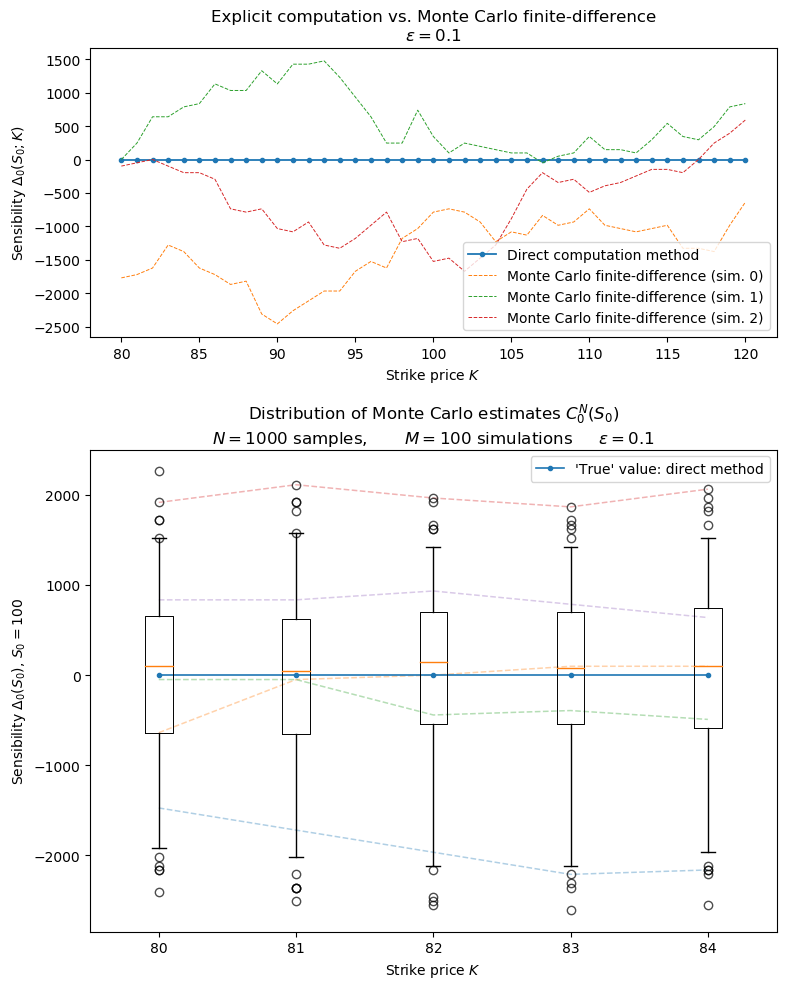

In [276]:
plot_delt0_comparison(1e-1)

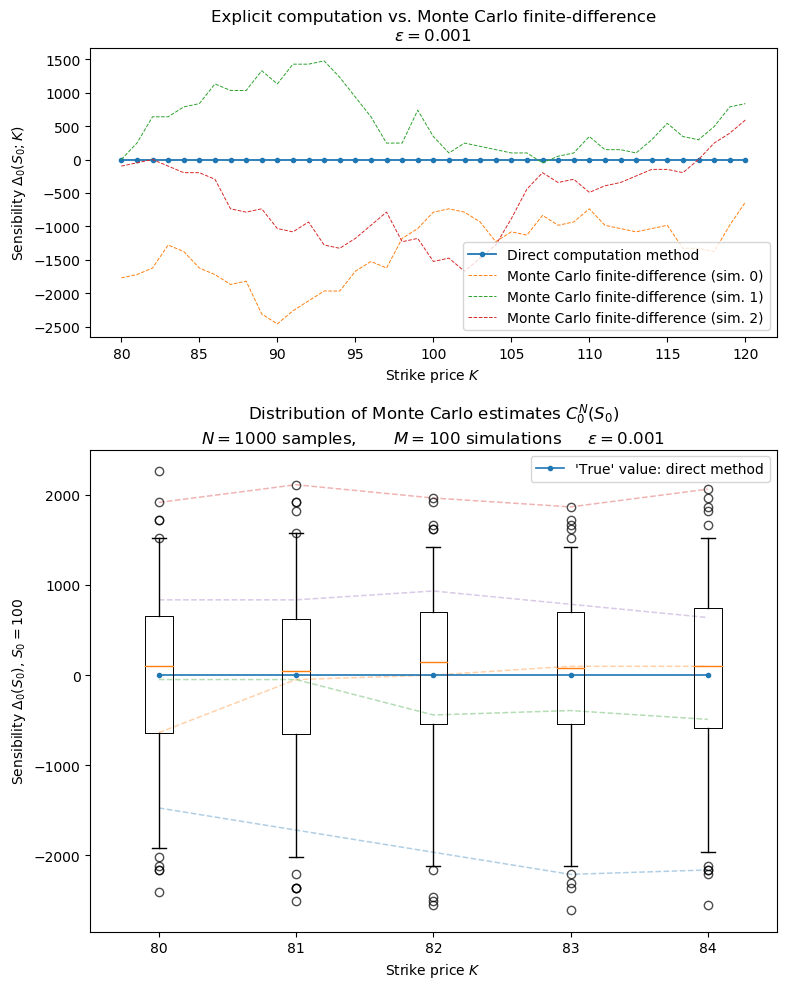

In [277]:
plot_delt0_comparison(1e-3)

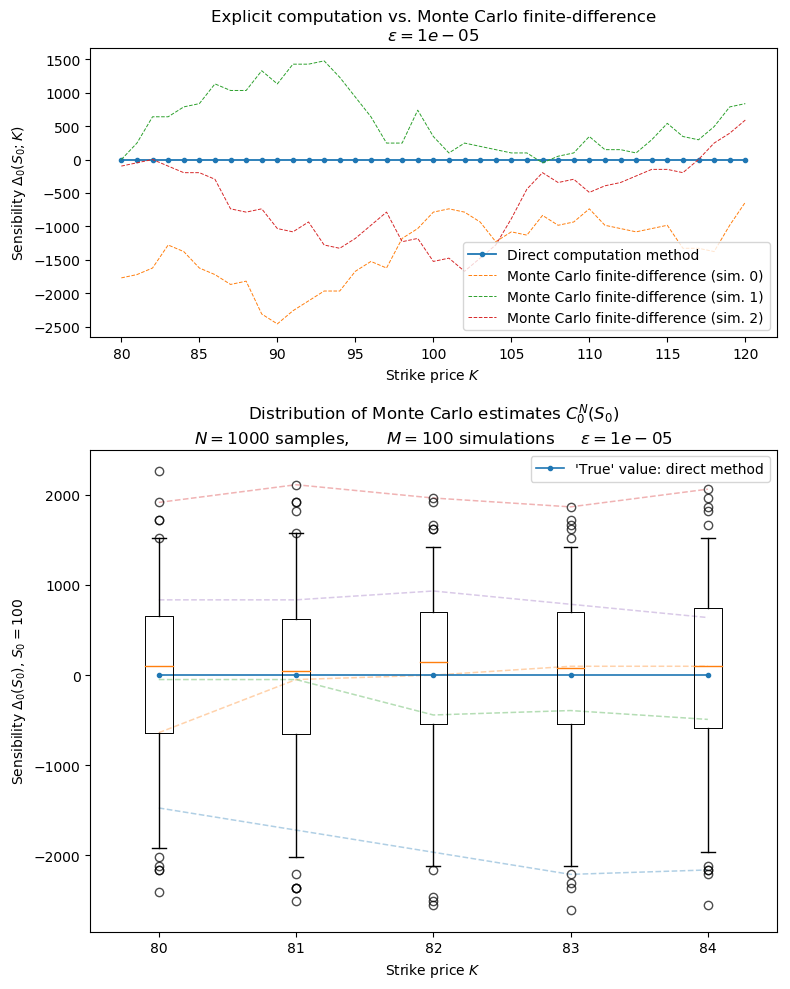

In [278]:
plot_delt0_comparison(1e-5)

The Monte Carlo finite-difference results have very high variance, and lowering $\epsilon$ makes it worse.